## Stock Price Prediction using LSTM + Random Forest with Feature Engineering and Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras.optimizers as optimizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import RegressorMixin, BaseEstimator

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"
df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


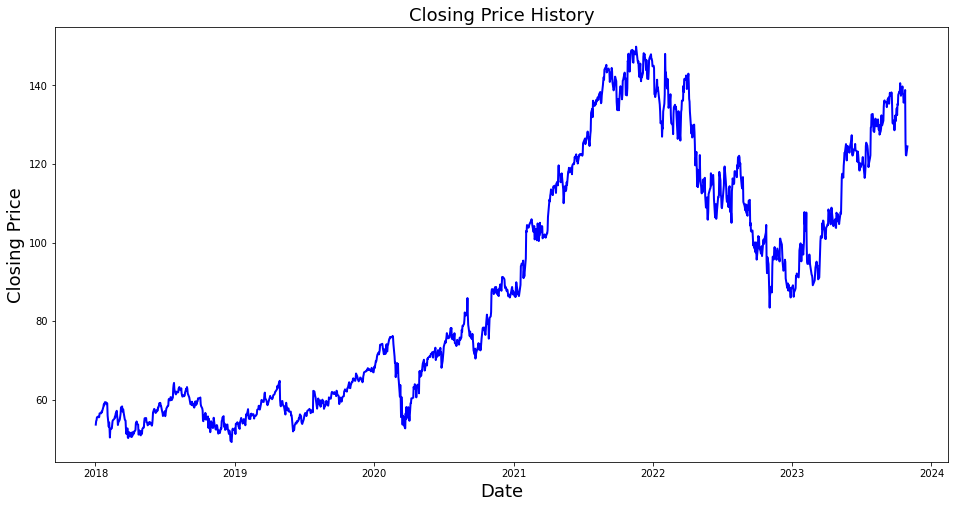

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='blue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [7]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [8]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [9]:
# Reshape input to be [samples, time steps, features]
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)

X_train_lstm shape:  (1166, 1, 7)
X_test_lstm shape:  (292, 1, 7)


In [11]:
# Create a Estimator class for LSTM model
class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the LSTM model
lstm_model = LSTMEstimator()
lstm_model.fit(X_train_lstm, y_train)

LSTMEstimator()

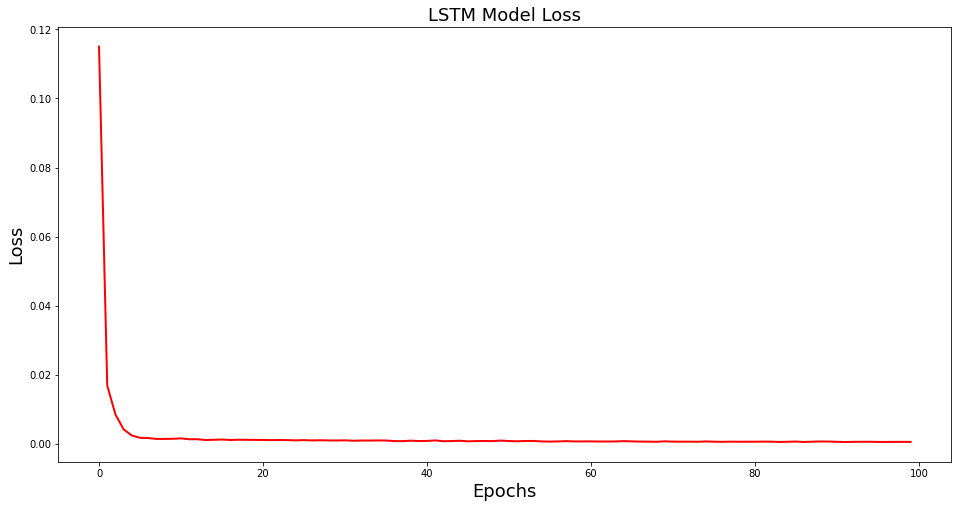

In [12]:
# Plot the training and validation loss for the LSTM model
plt.figure(figsize=(16,8))
plt.plot(lstm_model.model.history.history['loss'], linewidth=2, color='red')
plt.title('LSTM Model Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [13]:
# Build RF model
rf_model = RandomForestRegressor()
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [14]:
# Make predictions
lstm_pred = lstm_model.predict(X_test_lstm)
rf_pred = rf_model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [15]:
# Create a stacked model
stacked_pred = np.column_stack((lstm_pred, rf_pred))

# Train final regressor based on stacked predictions
final_regressor = LinearRegression().fit(stacked_pred, y_test)

final_pred = final_regressor.predict(stacked_pred)

In [16]:
# Inverse transform the predictions
lstm_pred_inv = target_scaler.inverse_transform(lstm_pred.reshape(-1,1))
rf_pred_inv = target_scaler.inverse_transform(rf_pred.reshape(-1,1))
final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1,1))

In [17]:
# Calculate the Evaluation Metrics for LSTM model
lstm_mse = mean_squared_error(y_test_inv, lstm_pred_inv)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_pred_inv))
lstm_mae = mean_absolute_error(y_test_inv, lstm_pred_inv)
lstm_r2 = r2_score(y_test_inv, lstm_pred_inv)

print("LSTM Model Evaluation Metrics")
print("=============================")
print("MSE: {:.4f}".format(lstm_mse))
print("RMSE: {:.4f}".format(lstm_rmse))
print("MAE: {:.4f}".format(lstm_mae))
print("R2: {:.4f}".format(lstm_r2))

LSTM Model Evaluation Metrics
MSE: 1.3946
RMSE: 1.1809
MAE: 0.9387
R2: 0.9947


In [18]:
# Calculate the Evaluation Metrics for RF model
rf_mse = mean_squared_error(y_test_inv, rf_pred_inv)
rf_rmse = np.sqrt(mean_squared_error(y_test_inv, rf_pred_inv))
rf_mae = mean_absolute_error(y_test_inv, rf_pred_inv)
rf_r2 = r2_score(y_test_inv, rf_pred_inv)

print("Random Forest Model Evaluation Metrics")
print("=======================================")
print("MSE: {:.4f}".format(rf_mse))
print("RMSE: {:.4f}".format(rf_rmse))
print("MAE: {:.4f}".format(rf_mae))
print("R2: {:.4f}".format(rf_r2))

Random Forest Model Evaluation Metrics
MSE: 1.6455
RMSE: 1.2828
MAE: 0.9597
R2: 0.9937


In [19]:
# Calculate the Evaluation Metrics for Stacked model
final_mse = mean_squared_error(y_test_inv, final_pred_inv)
final_rmse = np.sqrt(mean_squared_error(y_test_inv, final_pred_inv))
final_mae = mean_absolute_error(y_test_inv, final_pred_inv)
final_r2 = r2_score(y_test_inv, final_pred_inv)

print("LSTM-RF Stacked Model Evaluation Metrics")
print("========================================")
print("MSE: {:.4f}".format(final_mse))
print("RMSE: {:.4f}".format(final_rmse))
print("MAE: {:.4f}".format(final_mae))
print("R2: {:.4f}".format(final_r2))

LSTM-RF Stacked Model Evaluation Metrics
MSE: 0.7830
RMSE: 0.8849
MAE: 0.6860
R2: 0.9970


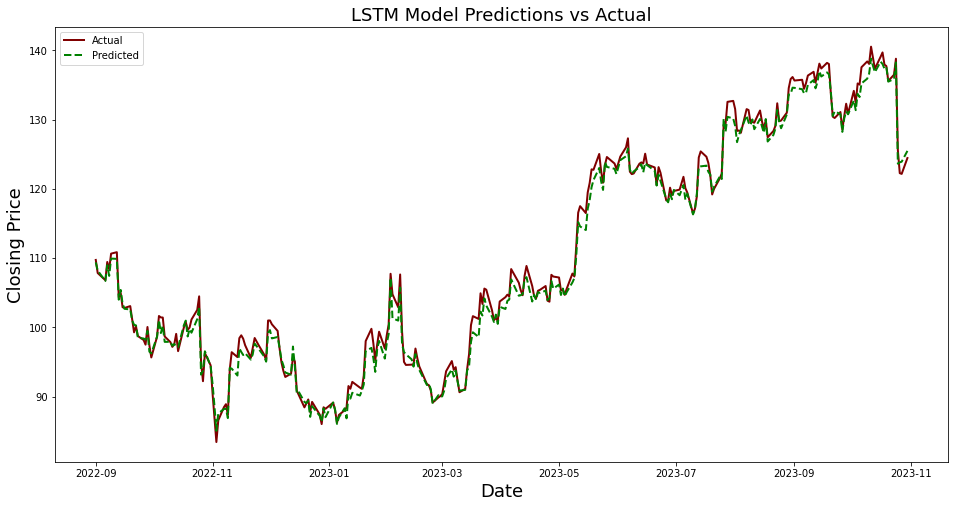

In [20]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='maroon', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], lstm_pred_inv, linewidth=2, color='green', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

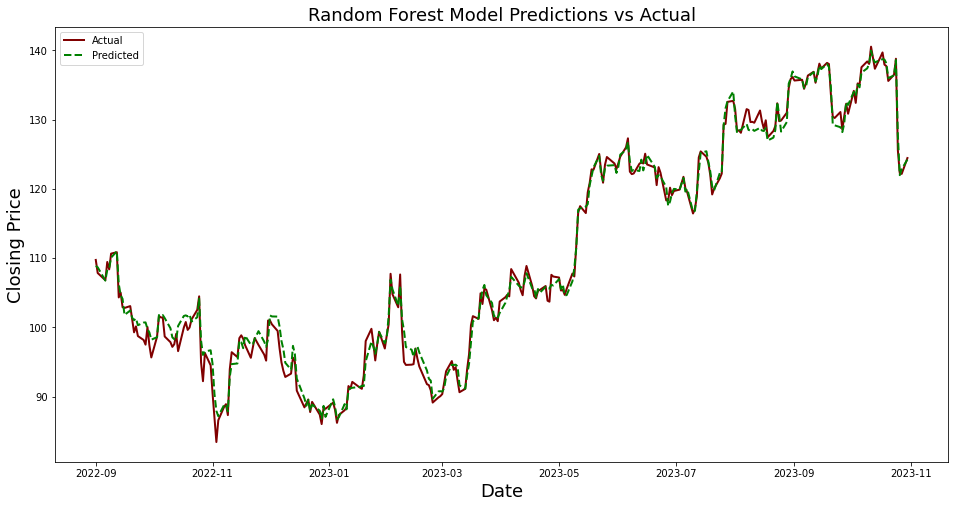

In [21]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('Random Forest Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='maroon', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], rf_pred_inv, linewidth=2, color='green', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

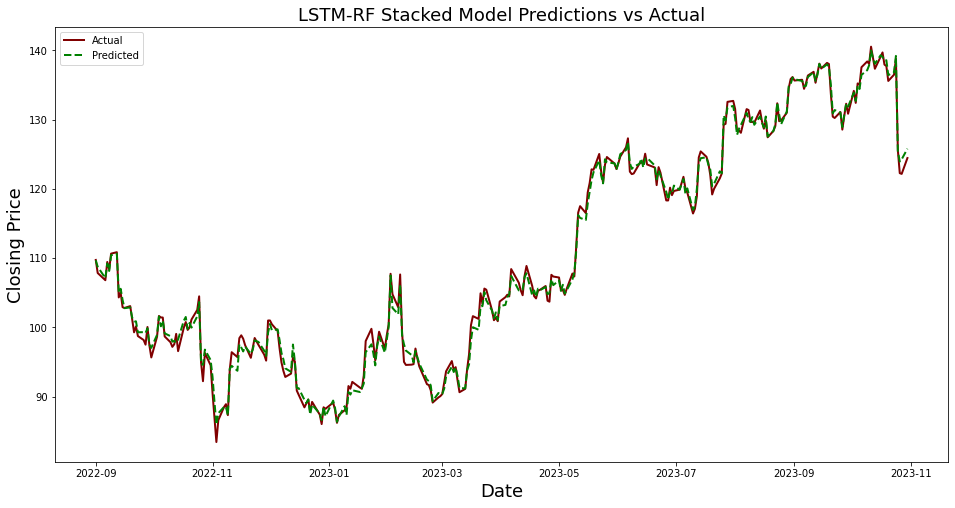

In [22]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('LSTM-RF Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='maroon', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='green', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [23]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'LSTM': lstm_pred_inv.flatten(), 'RF': rf_pred_inv.flatten(), 'LSTM-RF': final_pred_inv.flatten()})
df_pred

,Date,Actual,LSTM,RF,LSTM-RF
0,2022-09-01,109.739998,109.390076,108.868017,109.678704
1,2022-09-02,107.849998,108.201515,108.680691,108.752551
2,2022-09-06,106.809998,106.697670,106.752411,107.109008
3,2022-09-07,109.449997,108.977333,108.315592,109.221148
4,2022-09-08,108.379997,107.429611,108.535716,108.144566
...,...,...,...,...,...
287,2023-10-24,138.809998,138.272095,138.625745,139.214378
288,2023-10-25,125.610001,123.650986,127.814299,125.448583
289,2023-10-26,122.279999,123.838013,121.986765,123.960704
290,2023-10-27,122.169998,123.932648,122.851890,124.271583


In [24]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 21ms/step
Predicted Closing Prices for the Next 2 Days (LSTM Model):
Day 1:125.494
Day 2:122.082


In [25]:
last_features = X_scaled[-1:]

# Predict using the RF model
predicted_prices_rf = []

last_features_rf = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_rf = rf_model.predict(last_features_rf)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_rf = predicted_price_rf.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_rf = target_scaler.inverse_transform(predicted_price_reshaped_rf)[0][0]
    predicted_prices_rf.append(inverse_transformed_price_rf)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_rf = np.array([
        last_features_rf[0, 1], 
        last_features_rf[0, 2], 
        predicted_price_reshaped_rf[0, 0], 
        (predicted_price_reshaped_rf[0, 0] - last_features_rf[0, 3]) / last_features_rf[0, 3],
        np.mean(np.append(last_features_rf[0, 4:6], predicted_price_reshaped_rf[0, 0])),
        np.mean(np.append(last_features_rf[0, 5:], predicted_price_reshaped_rf[0, 0])),
        np.std(np.append(last_features_rf[0, 6:], predicted_price_reshaped_rf[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_rf = new_features_rf

print("Predicted Closing Prices for the Next 2 Days (RF Model):")
for i, price in enumerate(predicted_prices_rf):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (RF Model):
Day 1:124.252
Day 2:123.813


In [26]:
last_features = X_scaled[-1:]

# Predict using the Stacked LSTM-RF model
predicted_prices_stacked = []

for day in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predict using LSTM & RF models
    lstm_pred_for_stacking = lstm_model.predict(last_features_lstm).flatten()
    rf_pred_for_stacking = rf_model.predict(last_features).flatten()

    # Stacking LSTM and CNN predictions
    stacked_predictions = np.column_stack((lstm_pred_for_stacking, rf_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # For the next prediction, update the features with the newly predicted price.
    # We reuse the logic from LSTM to compute new features for simplicity.
    new_features_stacked = np.array([
        last_features[0, 1], 
        last_features[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features[0, 3]) / last_features[0, 3],
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Stacked LSTM-RF Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 38ms/step

Predicted Closing Prices for the Next 2 Days (Stacked LSTM-RF Model):
Day 1:125.810
Day 2:123.671


In [27]:
# LSTM model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['RMSprop', 'Adam', 'SGD']}

# Grid search on LSTM
grid = GridSearchCV(estimator=LSTMEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_lstm = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_lstm.best_params_)
print("Best score: ", grid_lstm.best_score_)
print("Best estimator: ", grid_lstm.best_estimator_)

# Using the best estimator for LSTM from the grid search
best_lstm_model = grid_lstm.best_estimator_

# Predicting the test data
pred_best_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_lstm_inv = target_scaler.inverse_transform(pred_best_lstm.reshape(-1,1))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9872088275808736
Best estimator:  LSTMEstimator(optimizer='Adam')
10/10 [==============================] - 0s 1ms/step


In [28]:
# Calculate the Evaluation Metrics for LSTM model with hyperparameter tuning
lstm_tuned_mse = mean_squared_error(y_test_inv, pred_best_lstm_inv)
lstm_tuned_rmse = np.sqrt(mean_squared_error(y_test_inv, pred_best_lstm_inv))
lstm_tuned_mae = mean_absolute_error(y_test_inv, pred_best_lstm_inv)
lstm_tuned_r2 = r2_score(y_test_inv, pred_best_lstm_inv)

print("Tuned LSTM Model Evaluation Metrics")
print("====================================")
print("MSE: {:.4f}".format(lstm_tuned_mse))
print("RMSE: {:.4f}".format(lstm_tuned_rmse))
print("MAE: {:.4f}".format(lstm_tuned_mae))
print("R2: {:.4f}".format(lstm_tuned_r2))

Tuned LSTM Model Evaluation Metrics
MSE: 0.8820
RMSE: 0.9391
MAE: 0.7512
R2: 0.9966


In [29]:
# Build Random Forest model with hyperparameter tuning
params = {'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt']}

rf = RandomForestRegressor()
grid_rf = GridSearchCV(estimator=rf, param_grid=params, cv=5, verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)
print("Best score: ", grid_rf.best_score_)
print("Best estimator: ", grid_rf.best_estimator_)
print("Best index: ", grid_rf.best_index_)
print("Scorer function: ", grid_rf.scorer_)

# Using the best estimator for RF from the grid search
best_rf_model = grid_rf.best_estimator_

# Predicting the test data
pred_best_rf = best_rf_model.predict(X_test)

# Inverse transform the predictions
pred_best_rf_inv = target_scaler.inverse_transform(pred_best_rf.reshape(-1,1))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best score:  0.9632226476614607
Best estimator:  RandomForestRegressor(max_depth=20, max_features='auto', n_estimators=300)
Best index:  110
Scorer function:  <function _passthrough_scorer at 0x000002020F1064C0>


In [30]:
# Calculate the Evaluation Metrics for RF model with hyperparameter tuning
rf_tuned_mse = mean_squared_error(y_test_inv, pred_best_rf_inv)
rf_tuned_rmse = np.sqrt(mean_squared_error(y_test_inv, pred_best_rf_inv))
rf_tuned_mae = mean_absolute_error(y_test_inv, pred_best_rf_inv)
rf_tuned_r2 = r2_score(y_test_inv, pred_best_rf_inv)

print("Tuned Random Forest Model Evaluation Metrics")
print("============================================")
print("MSE: {:.4f}".format(rf_tuned_mse))
print("RMSE: {:.4f}".format(rf_tuned_rmse))
print("MAE: {:.4f}".format(rf_tuned_mae))
print("R2: {:.4f}".format(rf_tuned_r2))

Tuned Random Forest Model Evaluation Metrics
MSE: 1.5671
RMSE: 1.2519
MAE: 0.9361
R2: 0.9940


In [31]:
# Create a stacked model
stacked_tuned_pred = np.column_stack((pred_best_lstm, pred_best_rf))

# Train final regressor based on stacked predictions
final_tuned_regressor = LinearRegression().fit(stacked_tuned_pred, y_test)

# Make predictions
final_tuned_pred = final_tuned_regressor.predict(stacked_tuned_pred)

# Inverse transform the predictions
final_tuned_pred_inv = target_scaler.inverse_transform(final_tuned_pred.reshape(-1,1))

In [32]:
# Calculate the Evaluation Metrics for Stacked model with hyperparameter tuning
final_tuned_mse = mean_squared_error(y_test_inv, final_tuned_pred_inv)
final_tuned_rmse = np.sqrt(mean_squared_error(y_test_inv, final_tuned_pred_inv))
final_tuned_mae = mean_absolute_error(y_test_inv, final_tuned_pred_inv)
final_tuned_r2 = r2_score(y_test_inv, final_tuned_pred_inv)

print("Tuned LSTM-RF Model Evaluation Metrics")
print("======================================")
print("MSE: {:.4f}".format(final_tuned_mse))
print("RMSE: {:.4f}".format(final_tuned_rmse))
print("MAE: {:.4f}".format(final_tuned_mae))
print("R2: {:.4f}".format(final_tuned_r2))

Tuned LSTM-RF Model Evaluation Metrics
MSE: 0.7624
RMSE: 0.8731
MAE: 0.6743
R2: 0.9971


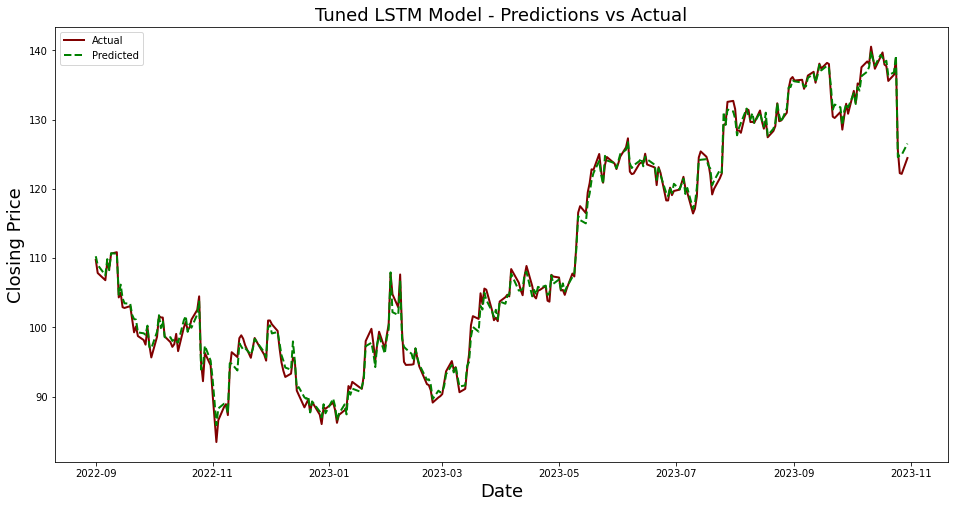

In [33]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM Model - Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='maroon', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_best_lstm_inv, linewidth=2, color='green', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

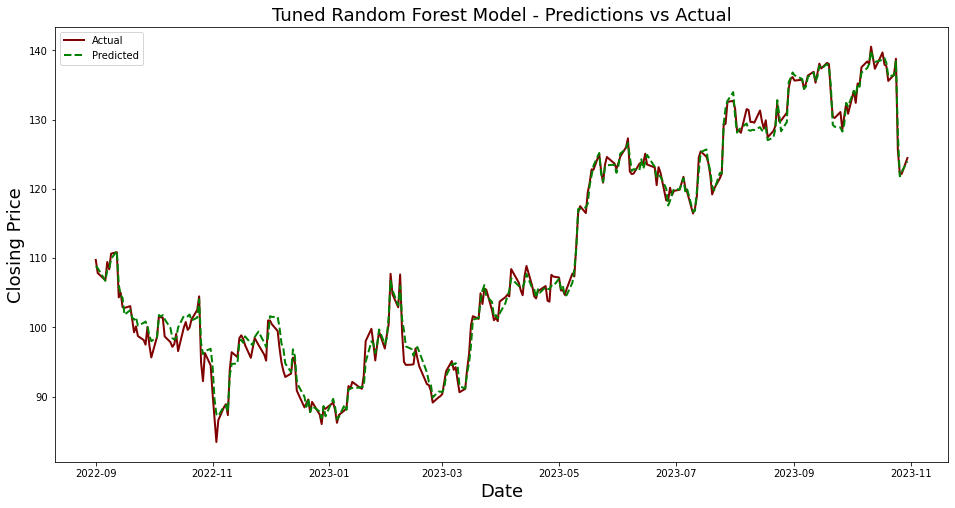

In [34]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('Tuned Random Forest Model - Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='maroon', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_best_rf_inv, linewidth=2, color='green', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

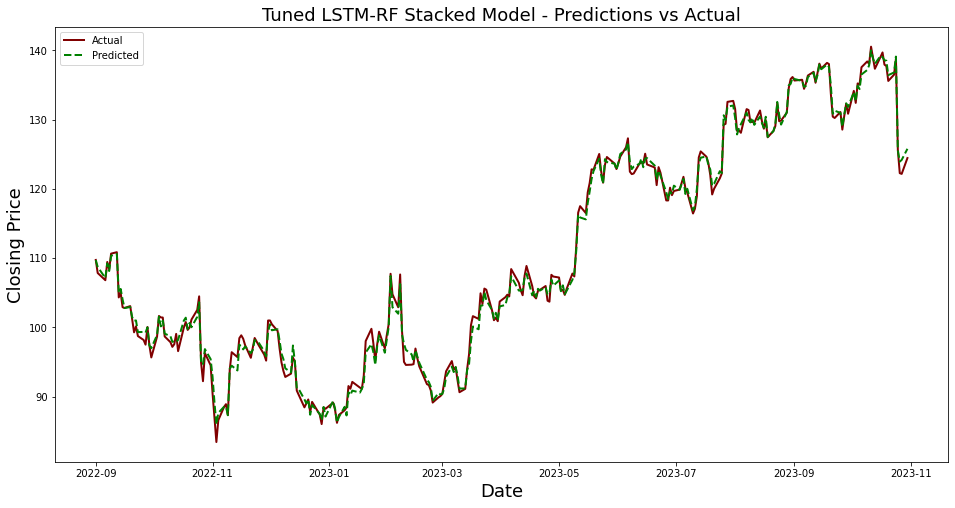

In [35]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM-RF Stacked Model - Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='maroon', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], final_tuned_pred_inv, linewidth=2, color='green', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [36]:
# Build a dataframe with actual and predicted prices
df_pred_1 = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'LSTM-Tuned': pred_best_lstm_inv.flatten(), 'RF-Tuned': pred_best_rf_inv.flatten(), 'Tuned LSTM-RF': final_tuned_pred_inv.flatten()})
df_pred_1.tail(20)

,Date,Actual,LSTM-Tuned,RF-Tuned,Tuned LSTM-RF
272,2023-10-03,132.429993,132.266113,133.447757,132.662831
273,2023-10-04,135.240005,134.722931,135.156073,134.922216
274,2023-10-05,135.070007,134.199020,134.758076,134.430545
275,2023-10-06,137.580002,136.293747,136.813974,136.532451
276,2023-10-09,138.419998,136.938492,137.452625,137.181125
277,2023-10-10,138.059998,137.637970,138.049507,137.856765
278,2023-10-11,140.550003,139.870316,139.958608,140.014234
279,2023-10-12,138.970001,138.740265,138.825700,138.873324
280,2023-10-13,137.360001,137.802933,138.346533,138.061864
281,2023-10-16,139.100006,139.367752,138.565862,139.246526


In [37]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = best_lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
Predicted Closing Prices for the Next 2 Days (Best LSTM Model):
Day 1:126.547
Day 2:123.466


In [38]:
last_features = X_scaled[-1:]

# Predict using the RF model
predicted_prices_rf = []

last_features_rf = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_rf = best_rf_model.predict(last_features_rf)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_rf = predicted_price_rf.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_rf = target_scaler.inverse_transform(predicted_price_reshaped_rf)[0][0]
    predicted_prices_rf.append(inverse_transformed_price_rf)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_rf = np.array([
        last_features_rf[0, 1], 
        last_features_rf[0, 2], 
        predicted_price_reshaped_rf[0, 0], 
        (predicted_price_reshaped_rf[0, 0] - last_features_rf[0, 3]) / last_features_rf[0, 3],
        np.mean(np.append(last_features_rf[0, 4:6], predicted_price_reshaped_rf[0, 0])),
        np.mean(np.append(last_features_rf[0, 5:], predicted_price_reshaped_rf[0, 0])),
        np.std(np.append(last_features_rf[0, 6:], predicted_price_reshaped_rf[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_rf = new_features_rf

print("Predicted Closing Prices for the Next 2 Days (Best RF Model):")
for i, price in enumerate(predicted_prices_rf):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (Best RF Model):
Day 1:123.979
Day 2:123.686


In [39]:
last_features = X_scaled[-1:]

# Predict using the Tuned LSTM-RF model
predicted_prices_stacked = []

for day in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predict using LSTM & RF models
    lstm_pred_for_stacking = best_lstm_model.predict(last_features_lstm).flatten()
    rf_pred_for_stacking = best_rf_model.predict(last_features).flatten()

    # Stacking LSTM and CNN predictions
    stacked_predictions = np.column_stack((lstm_pred_for_stacking, rf_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_tuned_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # For the next prediction, update the features with the newly predicted price.
    # We reuse the logic from LSTM to compute new features for simplicity.
    new_features_stacked = np.array([
        last_features[0, 1], 
        last_features[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features[0, 3]) / last_features[0, 3],
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Stacked LSTM-RF Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 22ms/step

Predicted Closing Prices for the Next 2 Days (Stacked LSTM-RF Model):
Day 1:125.795
Day 2:123.546
